In [81]:
import numpy as np
import pandas as pd

from scipy import stats

import json

from geopy.geocoders import Nominatim

import requests

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler 

import folium

import datetime as dt

Due to its large size, the crime data set is read chunk by chunk, each of which consists of 1 million observations. For simplicity, I only consider cases that happened during or after 2015. To do this, the Date column needs to be reformatted. The most important columns to be considered are ID, Date, Primary Type, District, Ward, Community Area, Latitude and Longitude.

In [2]:
chicago_chunk = pd.read_csv("Chicago_Crime.csv", chunksize = 1000000)

In [3]:
chunk_list = []
features = ['ID', 'Date', 'Primary Type', 'District', 'Ward', 'Community Area', 'Latitude', 'Longitude']

for chunk in chicago_chunk:   
    chunk_filter = chunk.loc[:,features]
    chunk_filter.dropna(inplace = True)
    chunk_filter['Date'] = pd.to_datetime(chunk_filter['Date'], format = '%m/%d/%Y %I:%M:%S %p')
    chunk_filter = chunk_filter.loc[chunk_filter['Date'] >= '01/01/2015',:]
    chunk_list.append(chunk_filter)
    
chicago_data = pd.concat(chunk_list)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The subset to be analyzed has over 1 million observations in total with 8 columns. The District, Ward and Community  Area columns need to be converted from float to integer.

In [41]:
print(chicago_data.shape)
chicago_data.head()

(1338577, 8)


,ID,Date,Primary Type,District,Ward,Community Area,Latitude,Longitude
0,11556037,2019-01-03 19:20:00,PUBLIC PEACE VIOLATION,16,41,76,42.002816,-87.906094
1,11626027,2019-03-16 17:58:00,BATTERY,1,42,32,41.883369,-87.633860
2,11622422,2019-03-12 22:00:00,THEFT,2,4,36,41.825347,-87.606781
3,11625922,2019-03-14 18:42:00,BATTERY,24,49,1,42.016542,-87.672499
4,11622907,2019-03-14 16:03:00,OTHER OFFENSE,2,4,36,41.825299,-87.606961


In [42]:
chicago_data.reset_index(drop = True, inplace = True)
chicago_data['District'] = chicago_data['District'].astype('int32')
chicago_data['Ward'] = chicago_data['Ward'].astype('int32')
chicago_data['Community Area'] = chicago_data['Community Area'].astype('int32')
chicago_data.head()

,ID,Date,Primary Type,District,Ward,Community Area,Latitude,Longitude
0,11556037,2019-01-03 19:20:00,PUBLIC PEACE VIOLATION,16,41,76,42.002816,-87.906094
1,11626027,2019-03-16 17:58:00,BATTERY,1,42,32,41.883369,-87.633860
2,11622422,2019-03-12 22:00:00,THEFT,2,4,36,41.825347,-87.606781
3,11625922,2019-03-14 18:42:00,BATTERY,24,49,1,42.016542,-87.672499
4,11622907,2019-03-14 16:03:00,OTHER OFFENSE,2,4,36,41.825299,-87.606961


A quick summary shows us the number of distinct districts, wards and community areas in the city of Chicago. There are 77 community areas and I will focus on these for the subsequent analysis. In addition, there are 33 distinct types of crime.

In [43]:
print('There are', len(chicago_data['District'].unique()), 'districts in Chicago')
print('There are', len(chicago_data['Ward'].unique()), 'wards in Chicago')
print('There are', len(chicago_data['Community Area'].unique()), 'community areas in Chicago')
print('There are', len(chicago_data['Primary Type'].unique()), 'types of crime in Chicago')

There are 23 districts in Chicago
There are 50 wards in Chicago
There are 77 community areas in Chicago
There are 33 types of crime in Chicago


To explore the data set in more details, I plot a barchart that displays the frequencies of the top 15 types of crime.

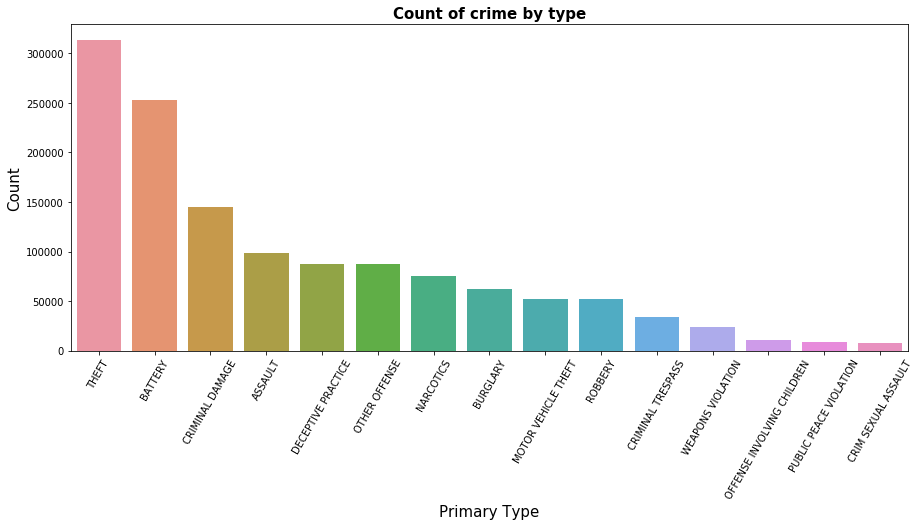

In [44]:
crime_count = pd.DataFrame(chicago_data['Primary Type'].value_counts()).reset_index()
crime_count.columns = ['Primary Type', 'Count']

plt.figure(figsize = (15,6))
ax = sns.barplot(x = 'Primary Type', y = 'Count', data = crime_count.head(15))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)
ax.set_xlabel(xlabel = 'Primary Type', fontsize = 15)
ax.set_ylabel(ylabel = 'Count', fontsize = 15)
ax.set_title('Count of crime by type', fontdict = {'fontweight':'bold', 'fontsize':15})
plt.show()

Next, I group the data set by community areas and plot a barchart that displays the 15 areas with the most cases of crime

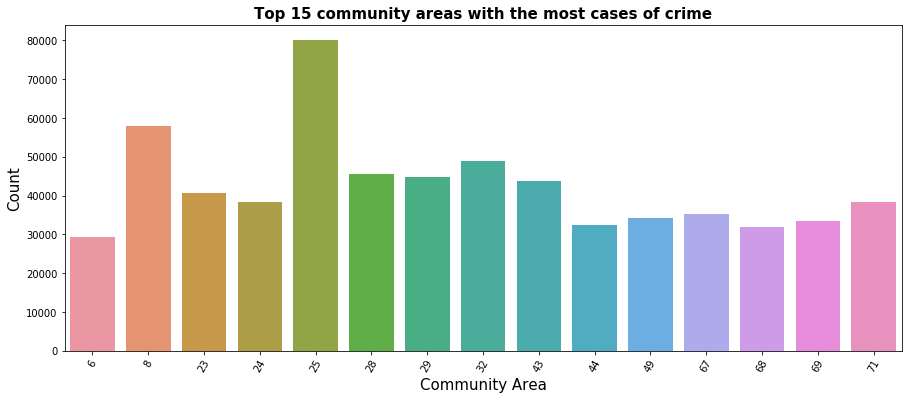

In [45]:
community_area_count = pd.DataFrame(chicago_data['Community Area'].value_counts()).reset_index()
community_area_count.columns = ['Community Area', 'Count']

plt.figure(figsize = (15,6))
ax = sns.barplot(x = 'Community Area', y = 'Count', data = community_area_count.head(15))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)
ax.set_xlabel(xlabel = 'Community Area', fontsize = 15)
ax.set_ylabel(ylabel = 'Count', fontsize = 15)
ax.set_title('Top 15 community areas with the most cases of crime', fontdict = {'fontweight':'bold', 'fontsize':15})
plt.show()

Although I do not have a data set that contains the precise locations of the community areas, I can use the crime data set to estimate their latitudes and longitudes. Specifically, for each community area, I take average of the longitudes and the latitudes over all cases of crime that happened in that area. Given the size of the data set, this simple procedure will give me very good estimates.

In [46]:
chicago_grouped = chicago_data.groupby('Community Area')

community_area_loc = pd.DataFrame(chicago_grouped['Latitude','Longitude'].mean())
community_area_loc.reset_index(inplace = True)
community_area_loc.head(10)

,Community Area,Latitude,Longitude
0,1,42.012195,-87.670609
1,2,41.999862,-87.693029
2,3,41.966217,-87.656876
3,4,41.972274,-87.688504
4,5,41.947509,-87.682949
5,6,41.943282,-87.653597
6,7,41.922531,-87.649465
7,8,41.897549,-87.630728
8,9,42.006081,-87.813256
9,10,41.984702,-87.801423


Given the locations of the community areas, I will then join the two data frames community_area_loc and community_area_count

In [47]:
community_area_merged = community_area_count.join(community_area_loc.set_index('Community Area'), 
                                                  on = 'Community Area')
community_area_merged.head(15)

,Community Area,Count,Latitude,Longitude
0,25,80077,41.890728,-87.758192
1,8,57949,41.897549,-87.630728
2,32,48924,41.880505,-87.627959
3,28,45465,41.876391,-87.661327
4,29,44765,41.861282,-87.716375
5,43,43846,41.761885,-87.573415
6,23,40650,41.900033,-87.720190
7,71,38394,41.746403,-87.655470
8,24,38339,41.902329,-87.676477
9,67,35292,41.776182,-87.665328


Next, I find the latitude and the longitude of the city of Chicago.

In [48]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent = "chicago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinates of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chicago are 41.8755616, -87.6244212.


Given the precise location of the city of Chicago, I can use the folium package to plot the map along with markers that correspond to the top 15 community areas with the most cases of crime. From the visualization, it seems that there are two clusters of areas in which there are many criminal activities.

In [49]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

for lat, lon, com, count in zip(community_area_merged.head(15)['Latitude'], 
                                community_area_merged.head(15)['Longitude'], 
                                community_area_merged.head(15)['Community Area'],
                                community_area_merged.head(15)['Count']):
    folium.Marker([lat, lon], 
                  popup = 'Community area: ' + str(com) + '; Number of cases: ' + str(count)).add_to(map_clusters)
       
map_clusters

For each community area, I calculate the percentage for each type of crime. That is, I count how many times a particular type of crime happened in that area and then divide the count by the total number of cases. As a result, the percentages in each row should sum to 1. This gives me a data frame with 77 rows and 34 columns as displayed below.

In [50]:
crime_proportion = chicago_grouped['Primary Type'].value_counts()/chicago_grouped['Primary Type'].count()

chicago_crime_prop = pd.DataFrame(crime_proportion)
chicago_crime_prop.columns = ['Count']
chicago_crime_prop.reset_index(inplace = True)
chicago_crime_prop = chicago_crime_prop.pivot_table(index = 'Community Area', columns = 'Primary Type')
chicago_crime_prop.columns = chicago_crime_prop.columns.droplevel()
chicago_crime_prop.fillna(0, inplace = True)
chicago_crime_prop.reset_index(inplace = True)

print(chicago_crime_prop.shape)
chicago_crime_prop.head(10)

(77, 34)


Primary Type,Community Area,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
0,1,0.000566,0.068413,0.188459,0.046175,0.000000,0.007825,0.125399,0.037424,0.062699,...,0.000051,0.059456,0.001441,0.000051,0.004479,0.036343,0.006486,0.000927,0.273860,0.008391
1,2,0.001109,0.065912,0.172573,0.065386,0.000175,0.005429,0.132349,0.027264,0.078055,...,0.000000,0.070057,0.000292,0.000058,0.004846,0.033452,0.006188,0.000525,0.240119,0.008348
2,3,0.000617,0.073823,0.193834,0.039798,0.000056,0.010146,0.086435,0.035762,0.102130,...,0.000056,0.057567,0.000168,0.000000,0.007119,0.031222,0.006054,0.000168,0.269058,0.007623
3,4,0.000627,0.058996,0.162786,0.058160,0.000209,0.009293,0.115067,0.029863,0.102851,...,0.000104,0.058996,0.000313,0.000000,0.003550,0.023598,0.005743,0.001149,0.289235,0.005325
4,5,0.001464,0.045248,0.093279,0.077317,0.000000,0.004979,0.110119,0.028555,0.118026,...,0.000000,0.044370,0.000293,0.000146,0.004100,0.029873,0.004393,0.001318,0.367989,0.002636
5,6,0.000918,0.041417,0.135779,0.055495,0.000170,0.008773,0.082427,0.033358,0.117077,...,0.000068,0.036181,0.000170,0.000034,0.006019,0.036283,0.004387,0.000612,0.385473,0.002346
6,7,0.001005,0.031331,0.087098,0.054213,0.000137,0.005526,0.100388,0.024389,0.102215,...,0.000000,0.026307,0.000046,0.000091,0.003288,0.031971,0.004933,0.000639,0.479242,0.001918
7,8,0.000449,0.041657,0.120675,0.017584,0.000155,0.007369,0.052546,0.030389,0.142487,...,0.000017,0.028370,0.001415,0.000086,0.005160,0.030389,0.003227,0.000777,0.466289,0.003779
8,9,0.002946,0.077320,0.183358,0.043446,0.000000,0.005155,0.134757,0.037555,0.134021,...,0.000000,0.092784,0.000736,0.000000,0.007364,0.007364,0.004418,0.000736,0.205449,0.001473
9,10,0.001831,0.071060,0.152272,0.065568,0.000000,0.004993,0.132967,0.037777,0.110501,...,0.000000,0.076552,0.000999,0.000000,0.004826,0.009985,0.006490,0.001165,0.252954,0.001831


Using this result, I can build a clustering model using the K-means algorithm. In this case, I pick k = 5.

In [111]:
kclusters = 5

chicago_crime_cluster = chicago_crime_prop.drop('Community Area', axis = 1)

kmeans_crime = KMeans(n_clusters = kclusters, random_state = 0).fit(chicago_crime_cluster)

crime_labels = kmeans_crime.labels_
crime_labels[0:10]

array([2, 2, 2, 2, 3, 3, 3, 3, 2, 2], dtype=int32)

In [112]:
chicago_crime_prop['Cluster Labels'] = crime_labels

chicago_merged = community_area_loc
chicago_merged = chicago_merged.join(chicago_crime_prop.set_index('Community Area'), on = 'Community Area')
chicago_merged.head(10)

,Community Area,Latitude,Longitude,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Cluster Labels
0,1,42.012195,-87.670609,0.000566,0.068413,0.188459,0.046175,0.000000,0.007825,0.125399,...,0.059456,0.001441,0.000051,0.004479,0.036343,0.006486,0.000927,0.273860,0.008391,2
1,2,41.999862,-87.693029,0.001109,0.065912,0.172573,0.065386,0.000175,0.005429,0.132349,...,0.070057,0.000292,0.000058,0.004846,0.033452,0.006188,0.000525,0.240119,0.008348,2
2,3,41.966217,-87.656876,0.000617,0.073823,0.193834,0.039798,0.000056,0.010146,0.086435,...,0.057567,0.000168,0.000000,0.007119,0.031222,0.006054,0.000168,0.269058,0.007623,2
3,4,41.972274,-87.688504,0.000627,0.058996,0.162786,0.058160,0.000209,0.009293,0.115067,...,0.058996,0.000313,0.000000,0.003550,0.023598,0.005743,0.001149,0.289235,0.005325,2
4,5,41.947509,-87.682949,0.001464,0.045248,0.093279,0.077317,0.000000,0.004979,0.110119,...,0.044370,0.000293,0.000146,0.004100,0.029873,0.004393,0.001318,0.367989,0.002636,3
5,6,41.943282,-87.653597,0.000918,0.041417,0.135779,0.055495,0.000170,0.008773,0.082427,...,0.036181,0.000170,0.000034,0.006019,0.036283,0.004387,0.000612,0.385473,0.002346,3
6,7,41.922531,-87.649465,0.001005,0.031331,0.087098,0.054213,0.000137,0.005526,0.100388,...,0.026307,0.000046,0.000091,0.003288,0.031971,0.004933,0.000639,0.479242,0.001918,3
7,8,41.897549,-87.630728,0.000449,0.041657,0.120675,0.017584,0.000155,0.007369,0.052546,...,0.028370,0.001415,0.000086,0.005160,0.030389,0.003227,0.000777,0.466289,0.003779,3
8,9,42.006081,-87.813256,0.002946,0.077320,0.183358,0.043446,0.000000,0.005155,0.134757,...,0.092784,0.000736,0.000000,0.007364,0.007364,0.004418,0.000736,0.205449,0.001473,2
9,10,41.984702,-87.801423,0.001831,0.071060,0.152272,0.065568,0.000000,0.004993,0.132967,...,0.076552,0.000999,0.000000,0.004826,0.009985,0.006490,0.001165,0.252954,0.001831,2


Finally, I plot the clustering result on a map of the city of Chicago. 

In [113]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
plasma = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, com, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], 
                                  chicago_merged['Community Area'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(com) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = plasma[cluster - 1],
        fill = True,
        fill_color = plasma[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In the following analysis, I need to make use of the location data from Foursquare.

In [114]:
CLIENT_ID = 'AADZNFJL102ZBDR5UT4GCADHPFMT0GURPVQ5TFKTMPCHJZBV' 
CLIENT_SECRET = '04202ITCIA3HYLNLGU5NRPDX1WU55CUAIZELH5P0SQEIXSXP'
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AADZNFJL102ZBDR5UT4GCADHPFMT0GURPVQ5TFKTMPCHJZBV
CLIENT_SECRET:04202ITCIA3HYLNLGU5NRPDX1WU55CUAIZELH5P0SQEIXSXP


For each community area, I make an API call to Foursquare to retrieve a list of popular venues in that area. In this case, the search radius is set to be 750 and I limit the result set to 100 venues. 

In [115]:
LIMIT = 100

def getNearbyVenues(areas, latitudes, longitudes, radius = 750):
    
    venues_list = []
    for area, lat, lng in zip(areas, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            area, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [116]:
chicago_venues = getNearbyVenues(areas = community_area_loc['Community Area'],
                                 latitudes = community_area_loc['Latitude'],
                                 longitudes = community_area_loc['Longitude'])

In [117]:
print(chicago_venues.shape)
chicago_venues.head(10)

(2892, 7)


,Community Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,42.012195,-87.670609,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
1,1,42.012195,-87.670609,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,1,42.012195,-87.670609,R Public House,42.016032,-87.668571,Sports Bar
3,1,42.012195,-87.670609,Taste Food & Wine,42.016086,-87.668488,Wine Shop
4,1,42.012195,-87.670609,Morse Fresh Market,42.008087,-87.667041,Grocery Store
5,1,42.012195,-87.670609,Bark Place,42.010080,-87.675223,Pet Store
6,1,42.012195,-87.670609,The Common Cup,42.007797,-87.667901,Coffee Shop
7,1,42.012195,-87.670609,Smack Dab,42.009291,-87.666201,Bakery
8,1,42.012195,-87.670609,Luzzat,42.015952,-87.668774,Indian Restaurant
9,1,42.012195,-87.670609,Romanian Kosher Sausage Co.,42.012765,-87.674692,Deli / Bodega


Next, I turn the Venue Category column into multiple dummy variables. Since there are 293 distinct categories of venue in the data frame, we have 293 corresponding dummy variables.

In [118]:
chicago_dummy = pd.get_dummies(chicago_venues[['Venue Category']], prefix = "", prefix_sep = "")
chicago_dummy = pd.concat([chicago_venues['Community Area'], chicago_dummy], axis = 1)
print(chicago_dummy.shape)
chicago_dummy.head(100)

(2892, 299)


,Community Area,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Notice that many categories of venue are under-represented in the data frame. Therefore, I decide to only include categories that appear more than 30 times across all community areas. This reduces the data frame to 25 columns (24 dummy varibles plus the Community Area column). This data frame will then be used to construct the clustering model.

In [119]:
chicago_dummy_grouped = chicago_dummy.groupby('Community Area').sum().reset_index()

total_venues = pd.DataFrame(chicago_dummy_grouped.iloc[:,1:].sum(axis = 0) > 30).reset_index()
total_venues.columns = ['Venue','Popular']
unpopular_venues = total_venues[total_venues['Popular'] == False]['Venue'].to_list()

chicago_dummy_grouped.drop(unpopular_venues, axis = 1, inplace = True)
print(chicago_dummy_grouped.shape)
chicago_dummy_grouped.head(10)

(77, 23)


,Community Area,American Restaurant,Bakery,Bar,Breakfast Spot,Bus Station,Café,Chinese Restaurant,Coffee Shop,Cosmetics Shop,...,Fried Chicken Joint,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pharmacy,Pizza Place,Sandwich Place,Train Station
0,1,2,2,3,1,1,1,2,2,1,...,0,1,0,0,7,4,1,3,4,2
1,2,2,0,1,0,1,0,2,0,0,...,1,5,0,0,1,1,1,1,1,0
2,3,1,0,4,1,1,1,3,7,0,...,1,2,1,0,3,1,1,4,2,0
3,4,1,0,5,0,2,3,1,1,2,...,0,1,2,2,2,1,1,2,4,0
4,5,3,1,3,2,2,0,1,3,1,...,1,1,1,1,2,0,1,6,3,1
5,6,0,4,2,1,0,2,0,4,0,...,1,1,0,2,3,1,0,3,4,0
6,7,3,1,3,2,0,1,0,6,2,...,2,1,3,2,1,1,0,5,2,0
7,8,6,2,2,3,0,1,0,3,0,...,0,1,3,3,1,0,0,2,0,0
8,9,1,1,3,0,1,0,1,1,0,...,0,1,0,4,2,2,0,1,0,0
9,10,1,0,2,0,1,1,1,0,0,...,0,0,0,0,1,4,1,3,0,0


Given the data frame above, I can also find the most popular categories of venue in each community area.

In [120]:
def most_common(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Community Area']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

area_venues_sorted = pd.DataFrame(columns = columns)
area_venues_sorted['Community Area'] = chicago_dummy_grouped['Community Area']

for ind in np.arange(chicago_dummy_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = most_common(chicago_dummy_grouped.iloc[ind, :], num_top_venues)

area_venues_sorted.head(10)

,Community Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Mexican Restaurant,Sandwich Place,Park,Pizza Place,Bar,Train Station,Bakery,Chinese Restaurant,Coffee Shop,Donut Shop
1,2,Grocery Store,American Restaurant,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bar,Bus Station,Discount Store,Sandwich Place,Donut Shop
2,3,Coffee Shop,Pizza Place,Bar,Mexican Restaurant,Chinese Restaurant,Grocery Store,Fast Food Restaurant,Sandwich Place,Discount Store,Donut Shop
3,4,Bar,Sandwich Place,Café,Cosmetics Shop,Pizza Place,Bus Station,Mexican Restaurant,Italian Restaurant,Gym / Fitness Center,Donut Shop
4,5,Pizza Place,American Restaurant,Sandwich Place,Bar,Coffee Shop,Mexican Restaurant,Breakfast Spot,Bus Station,Bakery,Chinese Restaurant
5,6,Bakery,Sandwich Place,Coffee Shop,Pizza Place,Mexican Restaurant,Italian Restaurant,Bar,Café,Donut Shop,Park
6,7,Coffee Shop,Pizza Place,American Restaurant,Gym / Fitness Center,Bar,Italian Restaurant,Fried Chicken Joint,Sandwich Place,Breakfast Spot,Cosmetics Shop
7,8,American Restaurant,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Breakfast Spot,Pizza Place,Bakery,Bar,Mexican Restaurant,Grocery Store
8,9,Italian Restaurant,Bar,Park,Mexican Restaurant,American Restaurant,Coffee Shop,Pizza Place,Bakery,Grocery Store,Bus Station
9,10,Park,Pizza Place,Bar,Donut Shop,Fast Food Restaurant,Bus Station,Café,Chinese Restaurant,Discount Store,American Restaurant


Finally, I build a clustering model using the K-means algorithm with k = 5. 

In [122]:
kclusters = 5

chicago_venue_cluster = chicago_dummy_grouped.drop('Community Area', axis = 1)
chicago_venue_cluster = StandardScaler().fit_transform(chicago_venue_cluster)

kmeans_venue = KMeans(n_clusters = kclusters, random_state = 0).fit(chicago_venue_cluster)

venue_labels = kmeans_venue.labels_ 
venue_labels[0:10]

array([0, 4, 0, 2, 0, 2, 2, 2, 3, 3], dtype=int32)

In [123]:
chicago_dummy_grouped['Cluster Labels'] = venue_labels
        
chicago_venue_merged = community_area_loc
chicago_venue_merged = chicago_venue_merged.join(chicago_dummy_grouped.set_index('Community Area'), on = 'Community Area')
chicago_venue_merged.head(10)

,Community Area,Latitude,Longitude,American Restaurant,Bakery,Bar,Breakfast Spot,Bus Station,Café,Chinese Restaurant,...,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pharmacy,Pizza Place,Sandwich Place,Train Station,Cluster Labels
0,1,42.012195,-87.670609,2,2,3,1,1,1,2,...,1,0,0,7,4,1,3,4,2,0
1,2,41.999862,-87.693029,2,0,1,0,1,0,2,...,5,0,0,1,1,1,1,1,0,4
2,3,41.966217,-87.656876,1,0,4,1,1,1,3,...,2,1,0,3,1,1,4,2,0,0
3,4,41.972274,-87.688504,1,0,5,0,2,3,1,...,1,2,2,2,1,1,2,4,0,2
4,5,41.947509,-87.682949,3,1,3,2,2,0,1,...,1,1,1,2,0,1,6,3,1,0
5,6,41.943282,-87.653597,0,4,2,1,0,2,0,...,1,0,2,3,1,0,3,4,0,2
6,7,41.922531,-87.649465,3,1,3,2,0,1,0,...,1,3,2,1,1,0,5,2,0,2
7,8,41.897549,-87.630728,6,2,2,3,0,1,0,...,1,3,3,1,0,0,2,0,0,2
8,9,42.006081,-87.813256,1,1,3,0,1,0,1,...,1,0,4,2,2,0,1,0,0,3
9,10,41.984702,-87.801423,1,0,2,0,1,1,1,...,0,0,0,1,4,1,3,0,0,3


To visualize the clustering result, the community areas are plotted on a map of the city of Chicago and colored according to the clusters they belong to.

In [124]:
map_venue_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Spectral(np.linspace(0, 1, len(ys)))
spectral = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, com, cluster in zip(chicago_venue_merged['Latitude'], chicago_venue_merged['Longitude'], 
                                  chicago_venue_merged['Community Area'], chicago_venue_merged['Cluster Labels']):
    label = folium.Popup(str(com) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = spectral[cluster - 1],
        fill = True,
        fill_color = spectral[cluster - 1],
        fill_opacity = 0.7).add_to(map_venue_clusters)
       
map_venue_clusters

In [125]:
contingency_table = np.zeros((5,5))
for i in np.arange(0,5):
    for j in np.arange(0,5):
        contingency_table[i,j] = np.sum((crime_labels == i) & (venue_labels == j))
contingency_table = contingency_table.astype('int32')
print('The observed contingency table is given by\n\n', contingency_table,'\n')
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction = False)
print('The expected frequencies are given in the following table\n\n', np.round(ex,2), '\n')
print('The test statistic is', np.round(chi2,2))
print('The degree of freedom is', dof)
print('The p-value is', np.round(p,10))

The observed contingency table is given by

 [[ 0  6  0  4 10]
 [ 1  8  0  4  4]
 [ 9  3  1 10  3]
 [ 2  0  7  1  0]
 [ 0  3  0  0  1]] 

The expected frequencies are given in the following table

 [[3.12 5.19 2.08 4.94 4.68]
 [2.65 4.42 1.77 4.19 3.97]
 [4.05 6.75 2.7  6.42 6.08]
 [1.56 2.6  1.04 2.47 2.34]
 [0.62 1.04 0.42 0.99 0.94]] 

The test statistic is 75.9
The degree of freedom is 16
The p-value is 9e-10


Next, I repeat the same procedure using hierarchical clustering with 5 clusters.

In [126]:
n_clusters = 5

agglom = AgglomerativeClustering(n_clusters, linkage = 'ward')
chicago_crime_agglom = agglom.fit(chicago_crime_cluster)

crime_labels = chicago_crime_agglom.labels_
crime_labels[0:10]

array([2, 2, 2, 2, 0, 0, 0, 0, 2, 2])

In [127]:
chicago_crime_prop.drop('Cluster Labels', axis = 1, inplace = True)
chicago_crime_prop['Cluster Labels'] = crime_labels

chicago_merged = community_area_loc
chicago_merged = chicago_merged.join(chicago_crime_prop.set_index('Community Area'), on = 'Community Area')
chicago_merged.head(10)

,Community Area,Latitude,Longitude,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Cluster Labels
0,1,42.012195,-87.670609,0.000566,0.068413,0.188459,0.046175,0.000000,0.007825,0.125399,...,0.059456,0.001441,0.000051,0.004479,0.036343,0.006486,0.000927,0.273860,0.008391,2
1,2,41.999862,-87.693029,0.001109,0.065912,0.172573,0.065386,0.000175,0.005429,0.132349,...,0.070057,0.000292,0.000058,0.004846,0.033452,0.006188,0.000525,0.240119,0.008348,2
2,3,41.966217,-87.656876,0.000617,0.073823,0.193834,0.039798,0.000056,0.010146,0.086435,...,0.057567,0.000168,0.000000,0.007119,0.031222,0.006054,0.000168,0.269058,0.007623,2
3,4,41.972274,-87.688504,0.000627,0.058996,0.162786,0.058160,0.000209,0.009293,0.115067,...,0.058996,0.000313,0.000000,0.003550,0.023598,0.005743,0.001149,0.289235,0.005325,2
4,5,41.947509,-87.682949,0.001464,0.045248,0.093279,0.077317,0.000000,0.004979,0.110119,...,0.044370,0.000293,0.000146,0.004100,0.029873,0.004393,0.001318,0.367989,0.002636,0
5,6,41.943282,-87.653597,0.000918,0.041417,0.135779,0.055495,0.000170,0.008773,0.082427,...,0.036181,0.000170,0.000034,0.006019,0.036283,0.004387,0.000612,0.385473,0.002346,0
6,7,41.922531,-87.649465,0.001005,0.031331,0.087098,0.054213,0.000137,0.005526,0.100388,...,0.026307,0.000046,0.000091,0.003288,0.031971,0.004933,0.000639,0.479242,0.001918,0
7,8,41.897549,-87.630728,0.000449,0.041657,0.120675,0.017584,0.000155,0.007369,0.052546,...,0.028370,0.001415,0.000086,0.005160,0.030389,0.003227,0.000777,0.466289,0.003779,0
8,9,42.006081,-87.813256,0.002946,0.077320,0.183358,0.043446,0.000000,0.005155,0.134757,...,0.092784,0.000736,0.000000,0.007364,0.007364,0.004418,0.000736,0.205449,0.001473,2
9,10,41.984702,-87.801423,0.001831,0.071060,0.152272,0.065568,0.000000,0.004993,0.132967,...,0.076552,0.000999,0.000000,0.004826,0.009985,0.006490,0.001165,0.252954,0.001831,2


In [128]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
plasma = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, com, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], 
                                  chicago_merged['Community Area'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(com) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = plasma[cluster - 1],
        fill = True,
        fill_color = plasma[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [129]:
n_clusters = 5

agglom = AgglomerativeClustering(n_clusters, linkage = 'ward')
chicago_venue_agglom = agglom.fit(chicago_venue_cluster)

venue_labels = chicago_venue_agglom.labels_
venue_labels[0:10]

array([4, 3, 0, 0, 0, 0, 0, 0, 1, 1])

In [130]:
chicago_dummy_grouped.drop('Cluster Labels', axis = 1, inplace = True)
chicago_dummy_grouped['Cluster Labels'] = venue_labels
        
chicago_venue_merged = community_area_loc
chicago_venue_merged = chicago_venue_merged.join(chicago_dummy_grouped.set_index('Community Area'), on = 'Community Area')
chicago_venue_merged.head(10)

,Community Area,Latitude,Longitude,American Restaurant,Bakery,Bar,Breakfast Spot,Bus Station,Café,Chinese Restaurant,...,Grocery Store,Gym / Fitness Center,Italian Restaurant,Mexican Restaurant,Park,Pharmacy,Pizza Place,Sandwich Place,Train Station,Cluster Labels
0,1,42.012195,-87.670609,2,2,3,1,1,1,2,...,1,0,0,7,4,1,3,4,2,4
1,2,41.999862,-87.693029,2,0,1,0,1,0,2,...,5,0,0,1,1,1,1,1,0,3
2,3,41.966217,-87.656876,1,0,4,1,1,1,3,...,2,1,0,3,1,1,4,2,0,0
3,4,41.972274,-87.688504,1,0,5,0,2,3,1,...,1,2,2,2,1,1,2,4,0,0
4,5,41.947509,-87.682949,3,1,3,2,2,0,1,...,1,1,1,2,0,1,6,3,1,0
5,6,41.943282,-87.653597,0,4,2,1,0,2,0,...,1,0,2,3,1,0,3,4,0,0
6,7,41.922531,-87.649465,3,1,3,2,0,1,0,...,1,3,2,1,1,0,5,2,0,0
7,8,41.897549,-87.630728,6,2,2,3,0,1,0,...,1,3,3,1,0,0,2,0,0,0
8,9,42.006081,-87.813256,1,1,3,0,1,0,1,...,1,0,4,2,2,0,1,0,0,1
9,10,41.984702,-87.801423,1,0,2,0,1,1,1,...,0,0,0,1,4,1,3,0,0,1


In [131]:
map_venue_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.Spectral(np.linspace(0, 1, len(ys)))
spectral = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, com, cluster in zip(chicago_venue_merged['Latitude'], chicago_venue_merged['Longitude'], 
                                  chicago_venue_merged['Community Area'], chicago_venue_merged['Cluster Labels']):
    label = folium.Popup(str(com) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = spectral[cluster - 1],
        fill = True,
        fill_color = spectral[cluster - 1],
        fill_opacity = 0.7).add_to(map_venue_clusters)
       
map_venue_clusters

In [133]:
contingency_table = np.zeros((5,5))
for i in np.arange(0,5):
    for j in np.arange(0,5):
        contingency_table[i,j] = np.sum((crime_labels == i) & (venue_labels == j))
contingency_table = contingency_table.astype('int32')
print('The observed contingency table is given by\n\n', contingency_table,'\n')
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction = False)
print('The expected frequencies are given in the following table\n\n', np.round(ex,2), '\n')
print('The test statistic is', np.round(chi2,2))
print('The degree of freedom is', dof)
print('The p-value is', np.round(p,10))

The observed contingency table is given by

 [[ 8  1  0  0  1]
 [ 0 14  1  2  0]
 [ 3 13  2  2  6]
 [ 0 12  1  6  1]
 [ 0  3  0  1  0]] 

The expected frequencies are given in the following table

 [[ 1.43  5.58  0.52  1.43  1.04]
 [ 2.43  9.49  0.88  2.43  1.77]
 [ 3.71 14.52  1.35  3.71  2.7 ]
 [ 2.86 11.17  1.04  2.86  2.08]
 [ 0.57  2.23  0.21  0.57  0.42]] 

The test statistic is 56.51
The degree of freedom is 16
The p-value is 2.0036e-06
